## Read in the data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import folium

In [2]:
# Define the sheets to read. We cannot use all years, as there is no birth data for the recent ones
sheets = ['Population de droit en ' + s for s in ['2011', '2012', '2013', '2014']] + ['population de droit en 2015']

In [3]:
pop_data_temp = pd.read_excel('./data/Population_de_droit_au_1_janvier,_par_commune,_par_sexe_2011_2017.xls', sheet_name = sheets,
                              skiprows = 1, usecols = 'A, B, E', dtype = {' code INS': str})

In [4]:
pop_data_temp.keys()

odict_keys(['Population de droit en 2011', 'Population de droit en 2012', 'Population de droit en 2013', 'Population de droit en 2014', 'population de droit en 2015'])

Convert the separate data frames into a single one

In [5]:
# Create a base data frame with the entity IDs and names
pop_data = pd.DataFrame(data = pop_data_temp['Population de droit en 2011'].dropna()[[' code INS', 'Lieu De Residence']])
pop_data.rename(columns = {' code INS': 'REFNIS'}, inplace = True)

In [6]:
# Merge each data frame into the base one
for key, value in pop_data_temp.items():
    value.rename(columns = {' code INS': 'REFNIS', 'Total': key[-4:]}, inplace = True)
    pop_data = pop_data.merge(value[['REFNIS', key[-4:]]], on = 'REFNIS', copy = False)

In [7]:
pop_data.head()

,REFNIS,Lieu De Residence,2011,2012,2013,2014,2015
0,1000,Belgique,10951266.0,11035948.0,11099554.0,11150516.0,11209044.0
1,4000,Région de Bruxelles-Capitale,1119088.0,1138854.0,1154635.0,1163486.0,1175173.0
2,21000,Arrondissement de Bruxelles-Capitale,1119088.0,1138854.0,1154635.0,1163486.0,1175173.0
3,21001,Anderlecht,107912.0,111279.0,113462.0,115178.0,116332.0
4,21002,Auderghem,31408.0,31963.0,32350.0,32560.0,32835.0


Besides municipalities, there is data for districts, provinces, regions and the whole Belgium. This will go away when merging the municipality shn codes<br>
Take the average across all years, as the information for a single year can be misleading, especially for small municipalities. Certainly not a statistically accurate method, but it will provide a decent estimate

In [8]:
# Create a new column for the average population
pop_data['Total_Population'] = 0
# Create the list of columns to average
cols_to_add = [col for col in pop_data.columns if col.isnumeric()]
# Sum up the yearly data
for col in cols_to_add:
    pop_data.Total_Population += pop_data[col]
# Divide by the number of columns
pop_data.Total_Population /= len(cols_to_add)
# Drop the yearly data, as it is no longer needed
for col in cols_to_add:
    pop_data.drop(col, axis = 1, inplace = True)
# Round the average data
pop_data.Total_Population = pop_data.Total_Population.astype(np.int64)

Read the birth information, which is in separate files for each year

In [9]:
file_names = ['BE_Naissances et fécondité_2011_FR_v3.xls', 'BE_Naissances et fécondité_2012_FR_v2.xls', 
              'BE_Naissances et fécondité_2013_FR_v2.xls', 'BE_Naissances et fécondité_2014_FR_v2.xls',
              'BE_Naissances et fécondité_2015prov_FR.xls']

In [11]:
# Read each file and merge it into the population data frame
for index, value in enumerate(file_names):
    birth_data = pd.read_excel('./data/' + value, sheet_name = 'Tab 2_201' + str(index + 1), skiprows = 1, usecols = 'A, F',
                               skipfooter = 2, dtype = {'REFNIS': str})
    birth_data.rename(columns = {'Total': str(index + 2011)}, inplace = True)
    pop_data = pop_data.merge(birth_data, on = 'REFNIS', copy = False)

Take one more time the average across all years

In [12]:
# Create a new column for the average number of births
pop_data['Total_Births'] = 0
# Create the list of columns to average
cols_to_add = [col for col in pop_data.columns if col.isnumeric()]
# Sum up the yearly data
for col in cols_to_add:
    pop_data.Total_Births += pop_data[col]
# Divide by the number of columns
pop_data.Total_Births /= len(cols_to_add)
# Drop the yearly data, as it is no longer needed
for col in cols_to_add:
    pop_data.drop(col, axis = 1, inplace = True)
# Round the average data
pop_data.Total_Births = pop_data.Total_Births.astype(np.int64)

Read the municipality shn codes. These are needed in order to map the municipalities to the geospatial information

In [14]:
# Read the municipality shn codes only
struct_be = pd.read_excel('./data/structure_be.xls', sheet_name = "unitlanguage", usecols = 'A', nrows = 589)

In [15]:
# Create the REFNIS column used for merging the population data
struct_be['REFNIS'] = struct_be.UT_ID.str.slice(start = 3)

In [16]:
# The territorial unit id is the same as the shn code in the geospatial data
struct_be.rename(columns = {'UT_ID': 'Shn'}, inplace = True)

In [17]:
pop_data = pop_data.merge(struct_be, on = 'REFNIS', copy = False)

## Exploratory Data Analysis

In [18]:
# Confirm that we have data for the 589 Belgian municipalities
pop_data.shape

(589, 5)

In [19]:
pop_data.head()

,REFNIS,Lieu De Residence,Total_Population,Total_Births,Shn
0,21001,Anderlecht,112832,1997,BE421001
1,21002,Auderghem,32223,403,BE421002
2,21003,Berchem-Sainte-Agathe,23345,355,BE421003
3,21004,Bruxelles,168844,2847,BE421004
4,21005,Etterbeek,46037,711,BE421005


In [20]:
# Confirm that we have no missing values
pop_data.isnull().sum()

REFNIS               0
Lieu De Residence    0
Total_Population     0
Total_Births         0
Shn                  0
dtype: int64

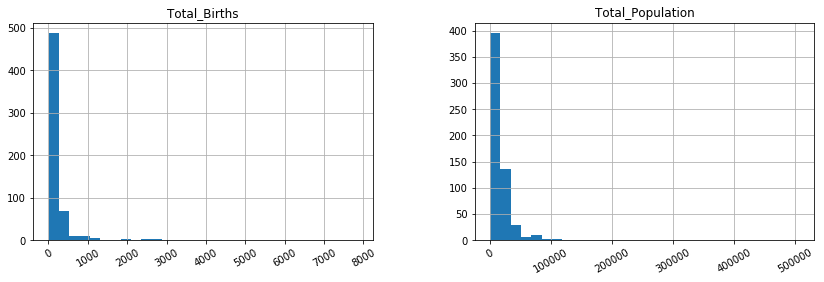

In [21]:
pop_data.hist(column = ['Total_Population', 'Total_Births'], bins = 30, figsize = (14, 4), xrot = 30);

The data is highly skewed, which is to be expected for population data

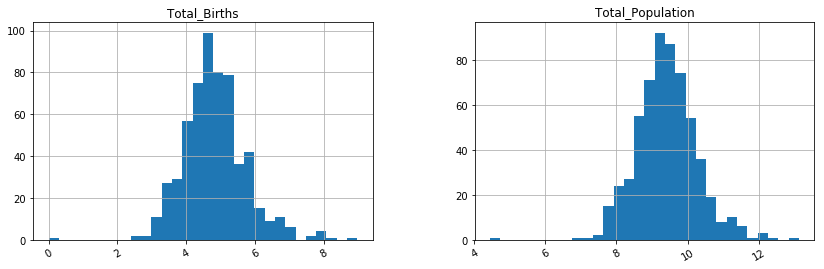

In [22]:
pop_data_temp = pop_data.copy()
pop_data_temp.Total_Population = np.log(pop_data_temp.Total_Population)
pop_data_temp.Total_Births = np.log(pop_data_temp.Total_Births)
pop_data_temp.hist(column = ['Total_Population', 'Total_Births'], bins = 30, figsize = (14, 4), xrot = 30);

Taking the log normalises the data, which is to be expected for skewed data

## Looking for Answers

In [23]:
np.corrcoef(pop_data.Total_Population, pop_data.Total_Births)[0, 1]

0.9831920433776759

There is near perfect correlation between the population and the number of births

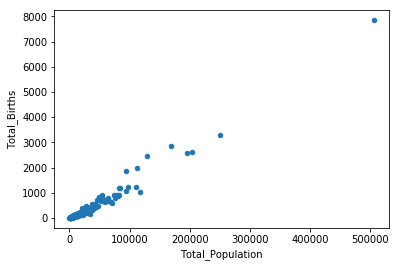

In [24]:
pop_data.plot.scatter(x = 'Total_Population', y = 'Total_Births', figsize = (6, 4));

However, there are some municipalities for whom the total births is double that of other municipalities with comparable population size (for instance at about 120k, there are some municipalities with 1000 total births and others with 2000 total births)<br>
Let us compute the birth rate per 1000 inhabitants

In [26]:
pop_data['Birth_Rate'] = pop_data.Total_Births / pop_data.Total_Population * 1000

In [27]:
pop_data['Birth_Rate'].describe()

count    589.000000
mean      10.334065
std        1.794336
min        4.963227
25%        9.303142
50%       10.137547
75%       11.071849
max       19.715108
Name: Birth_Rate, dtype: float64

The ratio between the minimum and maximum birth rate is 4, which is quite high

In [28]:
pop_data.sort_values(by = 'Birth_Rate', inplace = True)
pop_data.head(10)

,REFNIS,Lieu De Residence,Total_Population,Total_Births,Shn,Birth_Rate
215,38014,Koksijde,22163,110,BE238014,4.963227
163,31043,Knokke-Heist,33750,173,BE231043,5.125926
195,35029,De Haan,12543,71,BE235029,5.660528
216,38016,Nieuport,11418,68,BE238016,5.955509
272,45062,Horebeke,2060,13,BE245062,6.310680
39,11039,Schilde,19396,123,BE211039,6.341514
192,35011,Middelkerke,19101,125,BE235011,6.544160
348,25119,Lasne,14142,97,BE325119,6.859002
138,24048,Keerbergen,12819,88,BE224048,6.864810
162,31042,Zuienkerke,2747,19,BE231042,6.916636


In [29]:
pop_data.tail(10)

,REFNIS,Lieu De Residence,Total_Population,Total_Births,Shn,Birth_Rate
533,84033,Léglise,4917,78,BE384033,15.863331
12,21013,Saint-Gilles,49848,811,BE421013,16.269459
9,21010,Jette,49424,832,BE421010,16.833927
3,21004,Bruxelles,168844,2847,BE421004,16.861719
6,21007,Forest (Bruxelles-Capitale),53742,910,BE421007,16.932753
0,21001,Anderlecht,112832,1997,BE421001,17.698880
13,21014,Saint-Josse-ten-Noode,27295,490,BE421014,17.952006
14,21015,Schaerbeek,129324,2462,BE421015,19.037456
10,21011,Koekelberg,20957,409,BE421011,19.516152
11,21012,Molenbeek-Saint-Jean,94141,1856,BE421012,19.715108


Most of the low birth rate municipalities are in the Flemish region, while most of the high birth rate municipalities are in the Brussels region<br>
A visual representation of the birth rates can certainly help

In [27]:
# Create an empty map centred on Belgium
m = folium.Map(location = [50.5039, 4.4699], zoom_start = 8)

# Apply a GeoJSON overlay with the birth rate
m.choropleth(
    geo_data = './geojson/communes.geojson',
    data = pop_data,
    columns = ['Shn', 'Birth_Rate'],
    key_on = 'feature.properties.shn',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Birth Rate',
    #threshold_scale = [3.9, 7, 14, 35],
    highlight = True
)
# Display the map
m

NameError: name 'folium' is not defined

The map confirms the previous low/high birth rate findings. There are also some low birth rate municipalities in the southern part of the Wallon region<br>
What could explain these differences ?<br>
One possible answer might lie in the percentage of women of reproductive age, generally considered to be 15 to 49. If this percentage is significantly lower in the municipalities with low birth rate (due to population aging or young people leaving those municipalities)), this might explain, at least partially, the birth rate differences

In [30]:
# Define the file names to read
file_names = ['TF_SOC_POP_STRUCT_' + s + '.xlsx' for s in ['2011', '2012', '2013', '2014', '2015']]

In [30]:
# Read the files with the population structure by municipality, sex and age
for index, value in enumerate(file_names):
    pop_struct = pd.read_excel('./data/' + value, usecols = 'A, M, T, U',
                               #dtype = {'CD_MUNTY_REFNIS': str, 'CD_CIV_STS': np.int8, 'CD_AGE': np.int8, 'MS_POPULATION': np.int16})
                               dtype = {'CD_MUNTY_REFNIS': str})
    # Select only the women of reproductive age
    pop_struct_temp = pop_struct[(pop_struct.CD_SEX == 'F') & (pop_struct.CD_AGE.between(15, 49))]
    #pop_struct_temp = pop_struct_temp[['CD_MUNTY_REFNIS', 'MS_POPULATION']].groupby('CD_MUNTY_REFNIS').agg({'MS_POPULATION': np.sum}).reset_index()
    # Sum up the data per municipality and merge it into the main data frame
    pop_struct_temp = pop_struct_temp[['CD_MUNTY_REFNIS', 'MS_POPULATION']].groupby('CD_MUNTY_REFNIS').agg('sum').reset_index()
    pop_struct_temp.rename(columns = {'CD_MUNTY_REFNIS': 'REFNIS', 'MS_POPULATION': 'Total_Women_15_49_' + str(2011 + index)},
                           inplace = True)
    #pop_struct_temp['Total_Women_15_49_' + str(2011 + index)] = pop_struct_temp['Total_Women_15_49_' + str(2011 + index)].astype(np.int32)
    pop_data = pop_data.merge(pop_struct_temp, on = 'REFNIS', copy = False)
    
    #pop_struct_temp = pop_struct[(pop_struct.CD_SEX == 'F') & (pop_struct.CD_CIV_STS == 20) & (pop_struct.CD_AGE.between(15, 49))]
    #pop_struct_temp = pop_struct_temp[['CD_MUNTY_REFNIS', 'MS_POPULATION']].groupby('CD_MUNTY_REFNIS').agg('sum').reset_index()
    #pop_struct_temp.rename(columns = {'CD_MUNTY_REFNIS': 'REFNIS', 'MS_POPULATION': 'Total_Married_Women_15_49_' + str(2011 + index)},
    #                       inplace = True)
    #pop_struct_temp['Total_Married_Women_15_49_' + str(2011 + index)] = pop_struct_temp['Total_Married_Women_15_49_' + str(2011 + index)].astype(np.int32)
    #pop_data = pop_data.merge(pop_struct_temp, on = 'REFNIS', copy = False)

FileNotFoundError: [Errno 2] No such file or directory: 'TF_SOC_POP_STRUCT_2011.xlsx'

In [31]:
file_names = ['TF_SOC_POP_STRUCT_' + s + '.csv.gz' for s in ['2011', '2012', '2013', '2014', '2015']]
# Read the files sequentially
for index, value in enumerate(file_names):
    pop_struct = pd.read_csv(value, sep = ';', dtype = {'CD_MUNTY_REFNIS': str}, compression = 'gzip')
    # Select only the women of reproductive age
    pop_struct_temp = pop_struct[(pop_struct.CD_SEX == 'F') & (pop_struct.CD_AGE.between(15, 49))]
    #pop_struct_temp = pop_struct_temp[['CD_MUNTY_REFNIS', 'MS_POPULATION']].groupby('CD_MUNTY_REFNIS').agg({'MS_POPULATION': np.sum}).reset_index()
    # Sum up the data per municipality and merge it into the main data frame
    pop_struct_temp = pop_struct_temp[['CD_MUNTY_REFNIS', 'MS_POPULATION']].groupby('CD_MUNTY_REFNIS').agg('sum').reset_index()
    pop_struct_temp.rename(columns = {'CD_MUNTY_REFNIS': 'REFNIS', 'MS_POPULATION': 'Total_Women_15_49_' + str(2011 + index)},
                           inplace = True)
    #pop_struct_temp['Total_Women_15_49_' + str(2011 + index)] = pop_struct_temp['Total_Women_15_49_' + str(2011 + index)].astype(np.int32)
    pop_data = pop_data.merge(pop_struct_temp, on = 'REFNIS', copy = False)
    
    #pop_struct_temp = pop_struct[(pop_struct.CD_SEX == 'F') & (pop_struct.CD_CIV_STS == 20) & (pop_struct.CD_AGE.between(15, 49))]
    #pop_struct_temp = pop_struct_temp[['CD_MUNTY_REFNIS', 'MS_POPULATION']].groupby('CD_MUNTY_REFNIS').agg('sum').reset_index()
    #pop_struct_temp.rename(columns = {'CD_MUNTY_REFNIS': 'REFNIS', 'MS_POPULATION': 'Total_Married_Women_15_49_' + str(2011 + index)},
    #                       inplace = True)
    #pop_struct_temp['Total_Married_Women_15_49_' + str(2011 + index)] = pop_struct_temp['Total_Married_Women_15_49_' + str(2011 + index)].astype(np.int32)
    #pop_data = pop_data.merge(pop_struct_temp, on = 'REFNIS', copy = False)

In [32]:
# Create a new column for the average number of 15 to 49 women
pop_data['Total_Women_15_49'] = 0
# Create the list of columns to average
cols_to_add = [col for col in pop_data.columns if 'Total_Women_15_49_' in col]
# Sum up the yearly data
for col in cols_to_add:
    pop_data.Total_Women_15_49 += pop_data[col]
# Divide by the number of columns
pop_data.Total_Women_15_49 /= len(cols_to_add)
# Drop the yearly data, as it is no longer needed
for col in cols_to_add:
    pop_data.drop(col, axis = 1, inplace = True)
# Round the average data
pop_data.Total_Women_15_49 = pop_data.Total_Women_15_49.astype(np.int64)

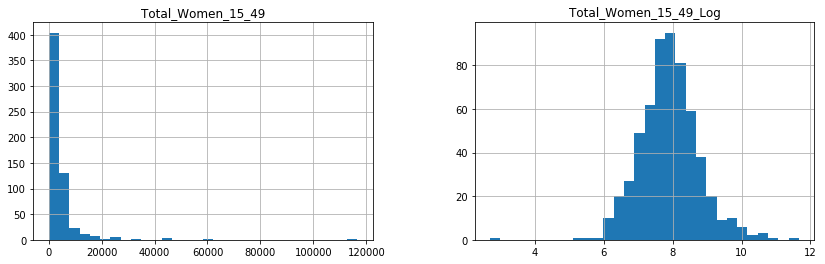

In [33]:
pop_data['Total_Women_15_49_Log'] = np.log(pop_data.Total_Women_15_49)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 4))

for xcol, ax in zip(['Total_Women_15_49', 'Total_Women_15_49_Log'], axes.reshape(2, )):
    pop_data.hist(column = xcol, bins = 30, ax = ax)

pop_data.drop('Total_Women_15_49_Log', axis = 1, inplace = True)

The data looks similar to the population data

In [34]:
# Compute the percentage of women of reproductive age
pop_data['Perc_Women_15_49'] = pop_data.Total_Women_15_49 / pop_data.Total_Population * 100
pop_data['Perc_Women_15_49'].describe()

count    589.000000
mean      22.257159
std        1.267584
min       15.295763
25%       21.667140
50%       22.237407
75%       22.794553
max       30.542561
Name: Perc_Women_15_49, dtype: float64

There are indeed significant differences among municipalities, which might explain the birth rate differences to some extent

In [35]:
np.corrcoef(pop_data.Total_Women_15_49, pop_data.Total_Births)[0, 1]

0.987830948266822

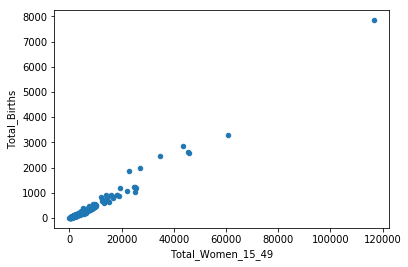

In [36]:
pop_data.plot.scatter(x = 'Total_Women_15_49', y = 'Total_Births', figsize = (6, 4));

The correlation is slightly higher than the one between population and number of births. There seems to be less scattering among municipalities with similar female populations, however, significant differences are still present<br>
Let us compute the birth rate per 1000 women

In [37]:
pop_data['Birth_Rate_Women_15_49'] = pop_data.Total_Births / pop_data.Total_Women_15_49 * 1000

In [38]:
pop_data['Birth_Rate_Women_15_49'].describe()

count    589.000000
mean      46.284306
std        6.508953
min       30.350877
25%       42.380137
50%       45.440714
75%       49.207673
max       81.353555
Name: Birth_Rate_Women_15_49, dtype: float64

The ratio between the minimum and maximum birth rate is about 2.7, less than the 4 we had before when we considered the total population. This is still a considerable difference<br>
Another idea is that, while the number of women of reproductive age is definitely important, this includes the bachelor, divorced and widowed women, which are less likely to have children. Let us take the marital status into account

In [36]:
# Read the files with the population structure by municipality, sex, age and marital status
for index, value in enumerate(file_names):
    pop_struct = pd.read_excel('./data/' + value, usecols = 'A, M, Q, T, U', dtype = {'CD_MUNTY_REFNIS': str})
    # Select only the married women of reproductive age
    pop_struct_temp = pop_struct[(pop_struct.CD_SEX == 'F') & (pop_struct.CD_CIV_STS == 20) & (pop_struct.CD_AGE.between(15, 49))]
    # Sum up the data per municipality and merge it into the main data frame
    pop_struct_temp = pop_struct_temp[['CD_MUNTY_REFNIS', 'MS_POPULATION']].groupby('CD_MUNTY_REFNIS').agg('sum').reset_index()
    pop_struct_temp.rename(columns = {'CD_MUNTY_REFNIS': 'REFNIS', 'MS_POPULATION': 'Total_Married_Women_15_49_' + str(2011 + index)},
                           inplace = True)
    pop_data = pop_data.merge(pop_struct_temp, on = 'REFNIS', copy = False)

FileNotFoundError: [Errno 2] No such file or directory: './data/TF_SOC_POP_STRUCT_2011.csv.gz'

In [39]:
file_names = ['TF_SOC_POP_STRUCT_' + s + '.csv.gz' for s in ['2011', '2012', '2013', '2014', '2015']]
# Read the files sequentially
for index, value in enumerate(file_names):
    pop_struct = pd.read_csv(value, sep = ';', dtype = {'CD_MUNTY_REFNIS': str}, compression = 'gzip')
    # Select only the women of reproductive age
    pop_struct_temp = pop_struct[(pop_struct.CD_SEX == 'F') & (pop_struct.CD_CIV_STS == 20) & (pop_struct.CD_AGE.between(15, 49))]
    # Sum up the data per municipality and merge it into the main data frame
    pop_struct_temp = pop_struct_temp[['CD_MUNTY_REFNIS', 'MS_POPULATION']].groupby('CD_MUNTY_REFNIS').agg('sum').reset_index()
    pop_struct_temp.rename(columns = {'CD_MUNTY_REFNIS': 'REFNIS', 'MS_POPULATION': 'Total_Married_Women_15_49_' + str(2011 + index)},
                           inplace = True)
    pop_data = pop_data.merge(pop_struct_temp, on = 'REFNIS', copy = False)

In [40]:
# Create a new column for the average number of married 15 to 49 women
pop_data['Total_Married_Women_15_49'] = 0
# Create the list of columns to average
cols_to_add = [col for col in pop_data.columns if 'Total_Married_Women_15_49_' in col]
# Sum up the yearly data
for col in cols_to_add:
    pop_data.Total_Married_Women_15_49 += pop_data[col]
# Divide by the number of columns
pop_data.Total_Married_Women_15_49 /= len(cols_to_add)
# Drop the yearly data, as it is no longer needed
for col in cols_to_add:
    pop_data.drop(col, axis = 1, inplace = True)
# Round the average data
pop_data.Total_Married_Women_15_49 = pop_data.Total_Married_Women_15_49.astype(np.int64)

In [41]:
# Compute the percentage of married women of reproductive age
pop_data['Perc_Married_Women_15_49'] = pop_data.Total_Married_Women_15_49 / pop_data.Total_Population * 100
pop_data['Perc_Married_Women_15_49'].describe()

count    589.000000
mean       8.742318
std        1.113720
min        5.739031
25%        7.983890
50%        8.739903
75%        9.530668
max       12.161887
Name: Perc_Married_Women_15_49, dtype: float64

We can see one more time significant differences among municipalities

In [42]:
np.corrcoef(pop_data.Total_Married_Women_15_49, pop_data.Total_Births)[0, 1]

0.9892141108779947

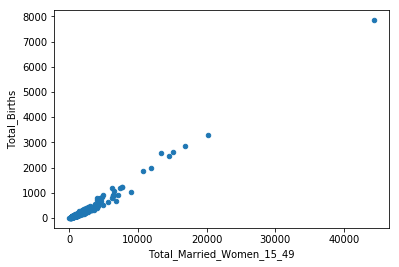

In [43]:
pop_data.plot.scatter(x = 'Total_Married_Women_15_49', y = 'Total_Births', figsize = (6, 4));

The correlation is slightly higher than the one between the number of women of reproductive age and number of births. There seems to be less scattering among municipalities with similar married female populations and the differences are less significant<br>
Let us compute the birth rate per 1000 married women

In [44]:
pop_data['Birth_Rate_Married_Women_15_49'] = pop_data.Total_Births / pop_data.Total_Married_Women_15_49 * 1000

In [45]:
pop_data['Birth_Rate_Married_Women_15_49'].describe()

count    589.000000
mean     119.545371
std       22.588971
min       71.038251
25%      102.241249
50%      115.988580
75%      133.928571
max      199.018405
Name: Birth_Rate_Married_Women_15_49, dtype: float64

The ratio between the minimum and maximum birth rate is about 2.8, slightly higher but close to the 2.7 we had before when we considered the number of women of reproductive age<br>
One more approach is to not only consider the number of women, married or not, but the number of couples. There might be (and definitely are in Belgium) non-married women who live in a couple and have children. Unfortunately the data available is for 2015 and later years, so we will use the 2015 data as a proxy for the average of 2011 to 2015

In [46]:
menages = pd.read_excel('./data/pop-typeHH_FR.xlsx', sheet_name = "01012015", skiprows = 5, usecols = 'A, F, G, H, I',
                        dtype = {'CODE REFNIS': str})

In [47]:
menages['Total_Couples'] = menages['2. Couples mariés sans enfant'] + menages['3. Couples mariés avec enfant(s)'] + \
    menages['4. Couples non-mariés sans enfant'] + menages['5. Couples non-mariés avec enfant(s)']

In [48]:
menages.rename(columns = {'CODE REFNIS': 'REFNIS'}, inplace = True)

In [49]:
pop_data = pop_data.merge(menages[['REFNIS', 'Total_Couples']], on = 'REFNIS', copy = False)

In [50]:
# Compute the number of couples per 100 inhabitants (a sort of a percentage)
pop_data['Perc_Couples'] = pop_data.Total_Couples / pop_data.Total_Population * 100
pop_data['Perc_Couples'].describe()

count    589.000000
mean      24.764921
std        2.274739
min       15.871039
25%       23.401309
50%       24.998743
75%       26.693360
max       28.521397
Name: Perc_Couples, dtype: float64

In [51]:
np.corrcoef(pop_data.Total_Couples, pop_data.Total_Births)[0, 1]

0.9612030518590166

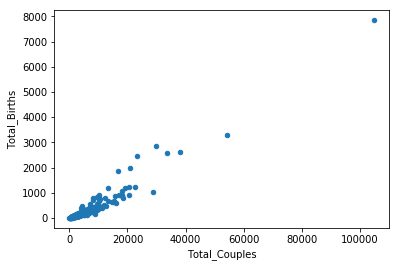

In [52]:
pop_data.plot.scatter(x = 'Total_Couples', y = 'Total_Births', figsize = (6, 4));

The correlation is higher than what we had so far and there seems to be more scattering among municipalities with similar number of couples

In [53]:
pop_data['Birth_Rate_Couples'] = pop_data.Total_Births / pop_data.Total_Couples * 1000

In [54]:
pop_data['Birth_Rate_Couples'].describe()

count    589.000000
mean      42.541344
std       11.501118
min       17.784964
25%       35.812672
50%       40.373991
75%       46.608214
max      113.111727
Name: Birth_Rate_Couples, dtype: float64

The ratio between the minimum and maximum birth rate is higher than 6, so it seems the number of couples is a worse indicator than what we had so far. This makes sense to a certain extent, because in the municipalities with more children, the number of couples/families will be lower (since the families are larger)<br>
We can also consider the number of married couples, but we are likely to face the same situation as the one explained in the previous sentence

In [55]:
menages['Total_Married_Couples'] = menages['2. Couples mariés sans enfant'] + menages['3. Couples mariés avec enfant(s)']

In [56]:
pop_data = pop_data.merge(menages[['REFNIS', 'Total_Married_Couples']], on = 'REFNIS', copy = False)

In [57]:
# Compute the number of married couples per 100 inhabitants (a sort of a percentage)
pop_data['Perc_Married_Couples'] = pop_data.Total_Married_Couples / pop_data.Total_Population * 100
pop_data['Perc_Married_Couples'].describe()

count    589.000000
mean      19.036762
std        2.490240
min       10.451773
25%       17.080336
50%       19.150785
75%       21.213389
max       23.778369
Name: Perc_Married_Couples, dtype: float64

In [58]:
np.corrcoef(pop_data.Total_Married_Couples, pop_data.Total_Births)[0, 1]

0.9568450984124356

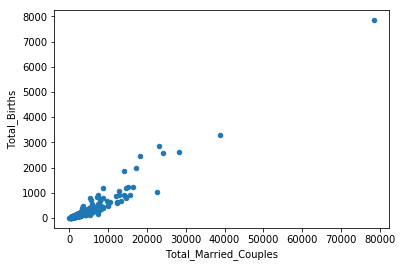

In [59]:
pop_data.plot.scatter(x = 'Total_Married_Couples', y = 'Total_Births', figsize = (6, 4));

The correlation and scatter plot are very similar to the previous ones (for all couples)

In [60]:
pop_data['Birth_Rate_Married_Couples'] = pop_data.Total_Births / pop_data.Total_Married_Couples * 1000

In [61]:
pop_data['Birth_Rate_Married_Couples'].describe()

count    589.000000
mean      55.999705
std       16.567831
min       20.872865
25%       45.193098
50%       52.605459
75%       63.385269
max      155.662188
Name: Birth_Rate_Married_Couples, dtype: float64

The ratio between the minimum and maximum birth rate is higher than 7, so no progress there

## Wrapping up

It seems that we cannot fully explain the birth rate differences between municipalities based on population structure alone. The best explanatory variable we found is the number of women of reproductive age, but there are still large differences that it does not account for<br>
It is normal to have differences which cannot be explained by only considering the population statistics. As outlined for instance by this article<br><br>
https://journals.openedition.org/eps/4550<br><br>
there are groups of municipalities with distinct ranges of birth rate due to a multitude of factors. A deeper, multi-variate analysis is needed in order to understand the reasons for these differences